In [1]:
import nbimporter
from Utils import *
import scipy
from tabulate import tabulate
from IPython.display import HTML, display

Importing Jupyter notebook from Utils.ipynb


## Li & Ben-dor method

### part-1 (triple point)

In [2]:
def triple_point_val(M_0,theta_w,p_0,rho_0,T_0,gamma=1.4,R=287):
    phi,M,p,rho,T,theta = three_shock_sym_RR_mach_rel(M_0,theta_w,p_0=p_0,rho_0=rho_0,T_0=T_0,gamma=gamma)
    
    phi_1 = phi[0]
    M_1   =   M[0]
    p_1   =   p[0]
    T_1   =   T[0]
    rho_1 = rho[0]
    theta_1 = theta[0]
    a_1 = np.sqrt(gamma*R*T_1)
    
    phi_2 = phi[1]
    M_2   =   M[1]
    p_2   =   p[1]
    T_2   =   T[1]
    rho_2 = rho[1]
    theta_2 = theta[1]
    a_2 = np.sqrt(gamma*R*T_2)
    
    phi_3 = phi[2]
    M_3   =   M[2]
    p_3   =   p[2]
    T_3   =   T[2]
    rho_3 = rho[2]
    theta_3 = theta[2]
    a_3 = np.sqrt(gamma*R*T_3)
    
    return phi_1,M_1,p_1,rho_1,a_1,theta_1,\
           phi_2,M_2,p_2,rho_2,a_2,theta_2,\
           phi_3,M_3,p_3,rho_3,a_3,theta_3


### part-2 (Mach stem base)

In [3]:
def mach_stem_base(M_0,p_0,rho_0,T_0,gamma=1.4,R = 287):
    M_G     = downstream_mach_no(np.pi/2,0,M_0,gamma=gamma)
    p_G,_   = downstream_pressure(np.pi/2,M_0,p_0,gamma=gamma)
    rho_G,_ = downstream_density(np.pi/2,M_0,rho_0,gamma=gamma)
    T_G,_   = downstream_temperature(np.pi/2,M_0,T_0,gamma=gamma)
    a_G     = np.sqrt(gamma*R*T_G)
    return M_G,p_G,rho_G,a_G

### part-3 (Shock fan interaction)

In [4]:
def shock_fan_inter(M_1,M_2,p_1,p_2,theta_3,theta_w,gamma=1.4):
    nu_M2 = prandtl_meyer_func(M_2,gamma)
    M_D = inv_prandtl_meyer_func(theta_3 + nu_M2,gamma)
    p_D = p_2*iso_entropic_pressure_rel(M_2,M_D,gamma)
    
    def constraint_eqn(V):
        M_C   = V[0]
        alpha = V[1]
        p_C   = V[2]
        M_C_d = V[3]
        phi_C = V[4]
        p_C_d = p_D
        theta_C_d = alpha
        
        F = np.zeros(np.shape(V))
        nu_MC = prandtl_meyer_func(M_C,gamma)
        nu_M1 = prandtl_meyer_func(M_1,gamma)
        
        F[0]  = (nu_MC-nu_M1) - (theta_w-alpha)
        F[1]  = p_C - p_1*iso_entropic_pressure_rel(M_1,M_C,gamma)
        F[2]  = M_C_d - downstream_mach_no(phi_C,alpha,M_C,gamma=gamma)
        F[3]  = theta_phi_rel(phi_C,M_C,theta_C_d,gamma)
        
        pCH,_ = downstream_pressure(phi_C,M_C,p_C,gamma)
        F[4]  = p_C_d - pCH
        return F
    
    init_val = np.array([2,0.2,50,2,0.5])
    soln,_,_,msg  = fsolve(constraint_eqn,init_val,full_output=True)
    M_C   = soln[0]
    alpha = soln[1]
    p_C   = soln[2]
    M_C_d = soln[3]
    phi_C = soln[4]
    p_C_d = p_D
    theta_C_d = alpha
    print(msg)
    
    return M_C,p_C,alpha,M_C_d,phi_C,p_C_d,theta_C_d,M_D,p_D
        
        

### part-4 (Geometric relations and subsonic region)

In [5]:
def OMEGA(d1,d2):
        F = np.arctan((2*np.tan(d1) + np.tan(d2-d1)) \
                  /(2-np.tan(d1)*np.tan(d2-d1)))
        return F

In [212]:
def geometric_rels(M_1,theta_w,M_C,M_2,M_3,theta_3,rho_3,a_3,M_D,\
                   M_G,a_G,rho_G,phi_1,phi_2,phi_C,alpha,M_C_d,H,W,gamma=1.4):
    mu_B = np.arcsin(1/M_1)
    x_R  = W*np.cos(theta_w)
#     y_R  = W*np.sin(theta_w)
    y_R  = H -W*np.sin(theta_w)
    c_RB = -np.tan(mu_B+theta_w)
    
    mu_C = np.arcsin(1/M_C)
    c_RC = -np.tan(mu_C+alpha)
    
    mu_2 = np.arcsin(1/M_2)
    c_BF = -np.tan(mu_2+theta_w)
    
    mu_D = np.arcsin(1/M_D)
    c_DE = -np.tan(mu_D)
    
    c_TB = np.tan(phi_2-theta_w)
    c_TF = -np.tan(theta_3)
    
    d_B  = phi_2-theta_w
    d_C  = phi_C-alpha
    c_BC = np.tan(OMEGA(d_B,d_C))
    
    d_C  = -np.arcsin(1/M_C_d)
    d_D  = -np.arcsin(1/M_D)
    c_CD =  np.tan(OMEGA(d_C,d_D))
    
    d_B  = theta_3
    d_D  = 0
    c_BD = np.tan(OMEGA(d_B,d_D))
    
    d_F  = -theta_3
    d_E  = 0
    c_FE = np.tan(OMEGA(d_F,d_E))
    
    u_3 = a_3*M_3
    u_G = a_G*M_G
    
    M_bar = 2*(rho_3*u_3*np.cos(theta_3)+rho_G*u_G)/\
            ((rho_3+rho_G)*(a_3 + a_G))
    
    def constraint_eqn(V):
        y_B = V[0]
        x_B = V[1]
        y_C = V[2]
        x_C = V[3]
        y_D = V[4]
        x_D = V[5]
        y_E = V[6]
        x_E = V[7]
        y_F = V[8]
        x_F = V[9]
        y_T = V[10]
        x_T = (H-y_T)/np.tan(phi_1)
        Hm  = y_T
        Hs  = y_E
        
        F = np.zeros(np.shape(V))
        
        F[0] = (y_B-y_R) - c_RB*(x_B-x_R)
        F[1] = (y_C-y_R) - c_RC*(x_C-x_R)
        F[2] = (y_F-y_B) - c_BF*(x_F-x_B)
        F[3] = (y_E-y_D) - c_DE*(x_E-x_D)
        F[4] = (y_B-y_T) - c_TB*(x_B-x_T)
        F[5] = (y_F-y_T) - c_TF*(x_F-x_T)
        F[6] = (y_B-y_C) - c_BC*(x_B-x_C)
        F[7] = (y_C-y_D) - c_CD*(x_C-x_D)
        F[8] = (y_B-y_D) - c_BD*(x_B-x_D)
        F[9] = (y_F-y_E) - c_FE*(x_F-x_E)
        F[10]= (Hm/Hs) - (1/M_bar)*((1/(gamma+1))*(2+(gamma-1)*M_bar**2))\
                                    **(0.5*(gamma+1)/(gamma-1))
        return F
        
        
    init_val = np.ones(11)*W*0.4
    soln,_,_,msg = fsolve(constraint_eqn,init_val,full_output=True)
    Hm = soln[10]
    Hs = soln[6]
    x_T = (H-soln[-1])/np.tan(phi_1)
    print(x_T)
    print(msg)
    return Hm,Hs,soln
    
    

In [229]:
M_0 = np.array([4])
theta_w  = 0.40166352
Ht_L  = 0.37
Ht    = 0.37
L     = Ht/Ht_L
W     = L/np.cos(theta_w)
# Hm,Hs,soln    = li_ben_dor_method(M_0,Ht,W,phi_0,theta_w,p_0,T_0,rho_0)
mach_stem_height,OT,s_s,FH,EF,TF,phi = mouton_method(M_0,Ht,W,phi_0,theta_w,p_0,T_0,rho_0)
# soln 
# np.rad2deg(0.40166352)
# H = Ht+W*np.sin(theta_w)
# Hm,Hs
# soln[7]
# 0.14127803/0.38183251
mach_stem_height,OT,s_s,FH,EF,TF
# np.sin(phi)*OT
# 0.666*
# OT*W
s_s*W
# np.rad2deg(0.40166352)

The solution converged.  mouton shock fan interaction
The solution converged.  mouton geo rel


0.047325830009331396

In [ ]:
0.2796753256574835 + 

In [166]:
def geometric_rels_liben_openjet(M_1,theta_1,M_2,M_3,a_3,rho_3,M_G,a_G,rho_G,theta_3,phi_1,phi_2,H,gamma=1.4):
    
    nu_M2 = prandtl_meyer_func(M_2,gamma)
    M_D = inv_prandtl_meyer_func(theta_3 + nu_M2,gamma)
   
    mu_D = np.arcsin(1/M_D)
    mu_2 = np.arcsin(1/M_2)
    
    u_3 = a_3*M_3
    u_G = a_G*M_G
    
    M_bar = 2*(rho_3*u_3*np.cos(theta_3)+rho_G*u_G)/\
            ((rho_3+rho_G)*(a_3 + a_G))
#     print(H)
    def constraint_eqn(V):
        H_m = V[0]
        x_T = V[1]
        y_D = V[2]
        x_D = V[3]
        y_E = V[4]
        x_E = V[5]
        y_F = V[6]
        x_F = V[7]
        Hs = y_E
        
        F = np.zeros(np.shape(V))
        
        F[0] = (H-H_m)   - np.tan(phi_1)*x_T
        F[1] = (H-y_D)   - np.tan(theta_1)*x_D
        F[2] = (y_D-H_m) - np.tan(phi_2-theta_1)*(x_D-x_T)
        F[3] = (H_m-y_F) - np.tan(theta_3)*(x_F-x_T)
        F[4] = (y_D-y_E) - np.tan(mu_D)*(x_E-x_D)
        F[5] = (y_F-y_D) + np.tan(theta_3 + mu_2)*(x_F-x_D)  # sign doubt
        F[6] = (y_F-y_E) - (np.tan(theta_3)/(2+np.tan(theta_3**2)))*(x_E-x_F)
        
        c_a = 2/(gamma+1)
        c_b = (gamma-1)*M_bar**2
        c_pow = 0.5*(gamma+1)/(gamma-1)

        F[7]= (H_m/Hs) - (1/M_bar)*(c_a+c_b)**c_pow
        return F
        
    c_a = 2/(gamma+1)
    c_b = (gamma-1)*M_bar**2
    c_pow = 0.5*(gamma+1)/(gamma-1)
#     print((1/M_bar)*(c_a+c_b)**c_pow)
    
    init_val = np.ones(8)*0.01
    soln,_,_,msg = fsolve(constraint_eqn,init_val,full_output=True)
    Hm = soln[0]
    Hs = soln[4]
    x_E = soln[5]
    x_T = soln[1]
    print(x_E,x_T)
    print(msg)
    return Hm,Hs,soln
    
    

In [8]:
def geometric_rels_lin_sol(M_1,theta_w,M_C,M_2,theta_3,M_D,phi_1,phi_2,phi_C,alpha,M_C_d,H,W,gamma=1.4):
    mu_B = np.arcsin(1/M_1)
    x_R  = W*np.sin(theta_w)
    y_R  = W*np.cos(theta_w)
    c_RB = -np.tan(mu_B+theta_w)
    
    mu_C = np.arcsin(1/M_C)
    c_RC = -np.tan(mu_C+alpha)
    
    mu_2 = np.arcsin(1/M_2)
    c_BF = -np.tan(mu_2+theta_w)
    
    mu_D = np.arcsin(1/M_D)
    c_DE = -np.tan(mu_D)
    
    c_TB = np.tan(phi_2-theta_w)
    c_TF = -np.tan(theta_3)
    
    d_B  = phi_2-theta_w
    d_C  = phi_C-alpha
    c_BC = np.tan(OMEGA(d_B,d_C))
    
    d_C  = -np.arcsin(1/M_C_d)
    d_D  = -np.arcsin(1/M_D)
    c_CD =  np.tan(OMEGA(d_C,d_D))
    
    d_B  = theta_3
    d_D  = 0
    c_BD = np.tan(OMEGA(d_B,d_D))
    
    d_F  = -theta_3
    d_E  = 0
    c_FE = np.tan(OMEGA(d_F,d_E))
    
    u_3 = a_3*M_3
    u_G = a_G*M_G
    
    M_bar = 2*(rho_3*u_3*np.cos(theta_3)+rho_G*u_G)/\
            ((rho_3+rho_G)*(a_3 + a_G))
    c_final = (1/M_bar)*((1/(gamma+1))*(2+(gamma-1)*M_bar**2))\
                                    **(0.5*(gamma+1)/(gamma-1))
    
    
    A = np.zeros([12,12])
    B = np.zeros(12)
    
    A[0,0],A[0,1] = 1,-c_RB
    
    A[1,2],A[1,3] = 1,-c_RC
    
    A[2,0],A[2,1],A[2,8],A[2,9] = -1,c_BF,1,-c_BF
    
    A[3,4],A[3,5],A[3,6],A[3,7] = -1,c_DE,1,-c_DE
    
    A[4,0],A[4,1],A[4,10],A[4,11] = 1,-c_TB,-1,c_TB
    
    A[5,8],A[5,9],A[5,10],A[5,11] = 1,-c_TF,-1,c_TF
    
    A[6,0],A[6,1],A[6,2],A[6,3]  = 1,-c_BC,-1,c_BC
    
    A[7,2],A[7,3],A[7,4],A[7,5]  = 1,-c_CD,-1,c_CD
    
    A[8,0],A[8,1],A[8,4],A[8,5]  = 1,-c_BD,-1,c_BD
    
    A[9,6],A[9,7],A[9,8],A[9,9]  = -1,c_FE,1,-c_FE
    
    A[10,10],A[10,11]  = 1,np.tan(phi_1)
    
    A[11,8],A[11,10]  = -c_final,1
    
    B[0] = y_R-c_RB*x_R
    B[1] = y_R-c_RC*x_R
    B[10] = H
        
    soln = np.linalg.solve(A, B)
        
    Hm = soln[10]
    Hs = soln[8]
    
#     print(A)
#     headers = ["yB","xB","yC","xC","yD","xD","yE","xE","yF","xF","yT","xT"]

#     # tabulate data
#     table = tabulate(A, headers,tablefmt="fancy_grid")
#     print(table)
    
#     table = tabulate(A, headers,tablefmt="html")
#     display(HTML(table))

    return Hm,Hs
    
    

### Li Ben-dor method for symmetric wedge

In [203]:
   
def li_ben_dor_method(M_0,Ht,W,phi_0,theta_w,p_0,T_0,rho_0):
    H = Ht+W*np.sin(theta_w)
    phi_1,M_1,p_1,rho_1,a_1,theta_1,\
    phi_2,M_2,p_2,rho_2,a_2,theta_2,\
    phi_3,M_3,p_3,rho_3,a_3,theta_3 = triple_point_val(M_0,theta_w,\
                                      p_0,rho_0,T_0,gamma=1.4,R=287)
#     print(np.rad2deg([phi_1,phi_2,phi_3]))
    print(np.rad2deg([theta_2,theta_3]))

    M_G,p_G,rho_G,a_G = mach_stem_base(M_0,p_0,rho_0,T_0,gamma=1.4,R=287)

    M_C,p_C,alpha,M_C_d,phi_C,p_C_d,theta_C_d,M_D,p_D = \
    shock_fan_inter(M_1,M_2,p_1,p_2,theta_3,theta_w,gamma=1.4)

    Hm,Hs,soln = geometric_rels(M_1,theta_w,M_C,M_2,M_3,theta_3,rho_3,a_3,M_D,\
                   M_G,a_G,rho_G,phi_1,phi_2,phi_C,alpha,M_C_d,H,W,gamma=1.4)

#     Hm1,Hs1 = geometric_rels_lin_sol(M_1,theta_w,M_C,M_2,theta_3,a_3,M_D \
#                       ,phi_1,phi_2,phi_C,alpha,M_C_d,H,W,gamma=1.4)



    return Hm,Hs,soln


### Li & Ben-Dor for openjet

In [234]:
def li_ben_dor_openjet(M_0,H,theta_w,p_0,T_0,rho_0):
    
    phi_1,M_1,p_1,rho_1,a_1,theta_1,\
    phi_2,M_2,p_2,rho_2,a_2,theta_2,\
    phi_3,M_3,p_3,rho_3,a_3,theta_3 = triple_point_val(M_0,theta_w,\
                                      p_0,rho_0,T_0,gamma=1.4,R=287)

    
    M_G,p_G,rho_G,a_G = mach_stem_base(M_0,p_0,rho_0,T_0,gamma=1.4,R=287)

    Hm,Hs,soln = geometric_rels_liben_openjet(M_1,theta_1,M_2,M_3,a_3,rho_3,M_G,a_G,rho_G,theta_3,phi_1,phi_2,H,gamma=1.4)

    print(M_1,np.rad2deg(phi_1),np.rad2deg(phi_3),np.rad2deg(phi_2),np.rad2deg(theta_2),np.rad2deg(theta_3),M_2,M_3)
    return Hm,Hs,soln

In [240]:
theta_w = np.deg2rad(30)
H = 1
M_0 = 4 

p_0   = 1
T_0   = 1
rho_0 = rho_fn(p_0,T_0,R=287)

Hm,Hs,soln = li_ben_dor_openjet(M_0,H,theta_w,p_0,T_0,rho_0)
# li_ben_dor_openjet(M_0,H,theta_w,p_0,T_0,rho_0)
print(soln[5])

1.3172070519979893 0.6056171707110682
The solution converged.
[1.84852208] 45.22407629990134 85.08529927758381 47.31365042773676 13.489637198866985 16.510362801133013 [1.36123466] [0.46767414]
1.3172070519979893


## Mouton's method

### Shock Fan interation

In [52]:
def shock_fan_inter_mounton(M_1,theta_1,phi_2,theta_3,gamma=1.4):
    
    def constraint_eqn(V):
        delta_e = V[0]
        M_1_d   = V[1]
        
        phi = phi_2-theta_1
        angle_1 = theta_1-theta_3-delta_e+phi
        angle_2 = theta_1-theta_3-delta_e
        C_A = (gamma+1)*M_1_d**2
        C_B = 2*((M_1_d*np.sin(angle_1))**2-1)
        
        F    = np.zeros(np.shape(V))
        F[0] = np.tan(angle_1)*np.tan(angle_2)*(C_A/C_B-1) - 1
        
        nuM1d = prandtl_meyer_func(M_1_d,gamma=gamma)
        nuM1  = prandtl_meyer_func(M_1,gamma=gamma)
        F[1]  = (delta_e+theta_3) - (nuM1d-nuM1)
        
        return F
    init_val = np.array([0,M_1],dtype='float64')
    soln,_,_,msg = fsolve(constraint_eqn,init_val,full_output=True)
    print(msg,' mouton shock fan interaction')
    
    delta_e = soln[0]
    M_1_d   = soln[1]
    
    
    return delta_e,M_1_d
    

### Geometric relations

In [51]:
def geometric_rel_mouton(M_1_d,M_2,M_a,theta_1,theta_3,phi_1,phi_2,H_s,gamma=1.4):
    Ar = (1/M_a)*((1/(gamma+1))*(2+(gamma-1)*M_a**2))\
                                    **(0.5*(gamma+1)/(gamma-1))
    phi = phi_2-theta_1
    
    nu_M2 = prandtl_meyer_func(M_2,gamma)
    M_2_d = inv_prandtl_meyer_func(theta_3 + nu_M2,gamma)
    mu1_d = np.arcsin(1/M_1_d)
    mu2_d = np.arcsin(1/M_2_d)
    
    def constraint_eqn(V):
        OT  = V[0]
        s_s = V[1]
        FH  = V[2]
        EF  = V[3]
        TF  = V[4]
        
        F    =  np.zeros(np.shape(V))
        F[0] = (np.sin(phi_1)*OT + Ar*s_s) - (H_s + np.sin(theta_1))
        F[1] = s_s + np.sin(theta_3+mu2_d)*FH + np.sin(mu1_d+theta_1)*EF - H_s
        F[2] = -np.cos(phi_1)*OT + (1-Ar)/np.tan(theta_3)*s_s + np.cos(theta_3+mu2_d)*FH \
                + np.cos(mu1_d+theta_1)*EF + np.cos(theta_1)
        F[3] = -np.cos(phi_1)*OT + np.cos(mu1_d+theta_1)*EF - np.cos(phi)*TF + np.cos(theta_1)
        F[4] = -np.sin(phi_1)*OT + np.sin(mu1_d+theta_1)*EF + np.sin(phi)*TF + np.sin(theta_1)
        
        return F
    init_val = np.ones(5)*0.5
    soln,_,_,msg = fsolve(constraint_eqn,init_val,full_output=True)
    
    print(msg,' mouton geo rel')
    OT  = soln[0]
    s_s = soln[1]
    FH  = soln[2]
    EF  = soln[3]
    TF  = soln[4]
    return s_s*Ar,OT,s_s,FH,EF,TF
        

### Mouton's method for symmetric wedge

In [222]:
   
def mouton_method(M_0,Ht,W,phi_0,theta_w,p_0,T_0,rho_0):
    H_s = Ht/W
    phi_1,M_1,p_1,rho_1,a_1,theta_1,\
    phi_2,M_2,p_2,rho_2,a_2,theta_2,\
    phi_3,M_3,p_3,rho_3,a_3,theta_3 = triple_point_val(M_0,theta_w,\
                                      p_0,rho_0,T_0,gamma=1.4,R=287)

    M_G,p_G,rho_G,a_G = mach_stem_base(M_0,p_0,rho_0,T_0,gamma=1.4,R=287)
    M_a = M_G
    delta_e,M_1_d = shock_fan_inter_mounton(M_1,theta_1,phi_2,theta_3,gamma=1.4)

#     print(delta_e,M_1_d,M_1,theta_3,theta_1)

    mach_stem_height,OT,s_s,FH,EF,TF = geometric_rel_mouton(M_1_d,M_2,M_a,theta_1,theta_3,phi_1,phi_2,H_s,gamma=1.4)
    
    return mach_stem_height*W,OT,s_s,FH,EF,TF,phi_1




In [180]:
M_0 = np.array([4])
# H_s  = 0.4
# theta_w = np.deg2rad(24)
# phi_0 = np.linspace(34,38,20)
# phi_0 = np.deg2rad(phi_0)
# phi_0 = np.deg2rad(36)
# theta_w = flow_deflection_angle(phi_0,M_0,gamma=1.4)
theta_w  = 0.40166352
Ht_L  = 0.37
Ht    = 0.37
L     = Ht/Ht_L
W     = L/np.cos(theta_w)
Hm,Hs,soln    = li_ben_dor_method(M_0,Ht,W,phi_0,theta_w,p_0,T_0,rho_0)
mach_stem_height,OT,s_s,FH,EF,TF = mouton_method(M_0,Ht,W,phi_0[i],theta_w[i],p_0,T_0,rho_0)

# H     = Ht + w*np.sin(theta_3)

# Ht_W  = 0.1
# Ht    = Ht_W
# W     = 0.5

# theta_w = np.deg2rad(30)
# W_H   = 0.8
# W = W_H
# H = 1
# Ht = H-W*np.sin(theta_w)


# p_0   = 10
# T_0   = 100
# rho_0 = rho_fn(p_0,T_0,R=287)

# Hm_li  = np.zeros(np.shape(phi_0))
# Hm_mou = np.zeros(np.shape(phi_0))
# for i in range(len(phi_0)):
#     Ht_L  = 0.37
#     Ht    = 0.37
#     L     = Ht/Ht_L
#     W     = L/np.cos(theta_w[i])
# #     print(ind,phi_0)
#     Hm_li[i]        = li_ben_dor_method(M_0,Ht,W,phi_0[i],theta_w[i],p_0,T_0,rho_0)
#     Hm_mou[i]       = mouton_method(M_0,Ht,W,phi_0[i],theta_w[i],p_0,T_0,rho_0)
# #     print(Hm_li[i] )

# li_ben_dor_method(M_0,Ht,W,phi_0,theta_w,p_0,T_0,rho_0)
# print(Hm_li/L,Hm_mou/L)
# np.rad2deg(theta_w)
# theta_w

The solution converged.
The solution converged.


(0.06472996257012303,
 0.043547459810030685,
 array([0.14127803, 1.20465813, 0.15324479, 1.2346413 , 0.14276797,
        1.24897393, 0.04354746, 1.38544796, 0.04799878, 1.25305085,
        0.06472996]))

<IPython.core.display.Javascript object>

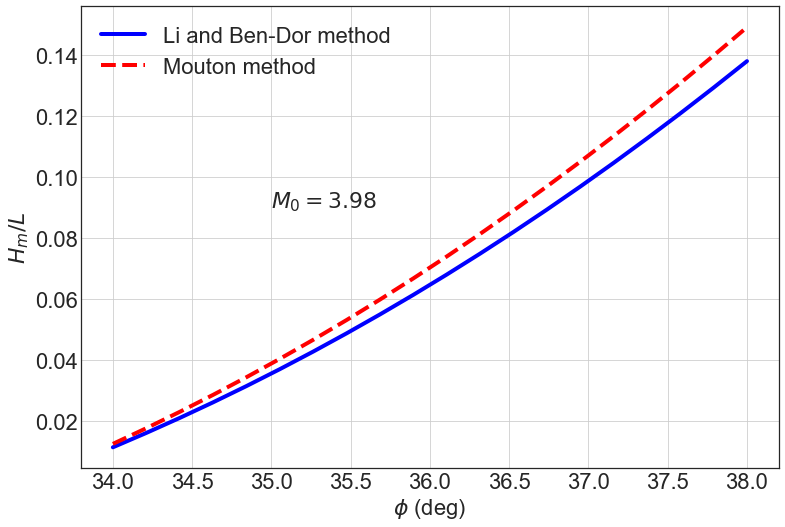

In [161]:

plt.style.use('seaborn-white')
%matplotlib inline

plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots()
fig.set_size_inches(12.5, 8.5, forward=True)
ax.plot(np.rad2deg(phi_0),Hm_li,'b',label='Li and Ben-Dor method',linewidth=4)
ax.plot(np.rad2deg(phi_0),Hm_mou,'r--',label = 'Mouton method',linewidth=4)
ax.set(xlabel='$\phi$ (deg)', ylabel='$H_m/L$',title='')
ax.grid()
ax.text(35,0.09,'$M_0 = 3.98$')
leg = ax.legend()
fig.savefig("test.png",transparent=True)
plt.show()

## Prandtl meyer function

In [13]:
def prandtl_meyer_func(M,gamma=1.4):
    g_p1 = gamma+1
    g_m1 = gamma-1
    
    f = (g_p1/g_m1)**0.5*np.arctan((g_m1*(M**2-1)/g_p1)**0.5)\
        - np.arctan((M**2-1)**0.5)
    return f

In [14]:
def inv_prandtl_meyer_func(theta,gamma=1.4):
    def constraint_eqn(M):
        return theta-prandtl_meyer_func(M,gamma)
    M_init = 1.5
    res=fsolve(constraint_eqn,M_init)
    return res

## Isoentropic relations

### pressure

In [15]:
def iso_entropic_pressure_rel(M_1,M_2,gamma=1.4):
    p2_p1 = ((2+(gamma-1)*M_1**2)/(2+(gamma-1)*M_2**2))**\
            (gamma/(gamma-1))
    return p2_p1
    

## Expansion fan pressure plots

In [267]:
def expan_fan_pressure_plot(M,no_points=50,gamma=1.4):
    nu_M1    = prandtl_meyer_func(M,gamma=gamma)
    nu_max = 0.5*np.pi*(np.sqrt((gamma+1)/(gamma-1)) -1)
    theta_max = nu_max - nu_M1 - 0.05
#     print(np.rad2deg(theta_max))
    
    theta = np.linspace(0,theta_max,no_points)
    # find M2
    p2p1 = np.zeros(no_points)
    M_2 = np.zeros(no_points)
    for i in range(no_points):
        nu_M2    = nu_M1 + theta[i]
        M2       = inv_prandtl_meyer_func(nu_M2,gamma=gamma)
        p2p1[i]  = iso_entropic_pressure_rel(M,M2,gamma=gamma)
        M_2[i]   = M2
        
    return theta,p2p1,M_2
        

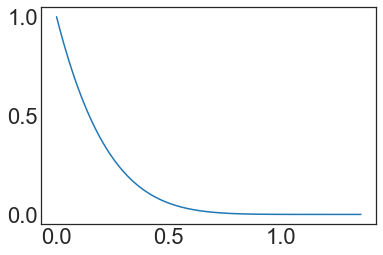

In [270]:
M = np.array([3])
theta,p2p1,M_2 = expan_fan_pressure_plot(M,no_points=100,gamma=1.4)
plt.plot(theta,p2p1)
plt.show()